In [1]:
# Importing libraries
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import os.path
from pathlib import Path
import glob

#librosa
from scipy.io.wavfile import read
import librosa as lbr
import librosa.display as lbl
import IPython
from IPython.display import Audio
import scipy

#Scaler and Transformation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


#Accuracy Control
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# keras 
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D,Reshape
from keras import models
from keras import layers
import tensorflow as tf
from keras.models import load_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#Ignoring warnings
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [2]:
### Loading dataset 
Main1_WAVRECORDING_Path = Path("/kaggle/input/audacity12/Audacity")
### Adding recording path
recd_Path = list(Main1_WAVRECORDING_Path.glob(r"**/*.wav"))
### Adding recording Label
recd_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],recd_Path))
### Adding sequance
recd_Path_Sequan = pd.Series(recd_Path,name="WAV").astype(str)
recd_Labels_Sequan = pd.Series(recd_Labels,name="sentiment")
### Adding Dataframe for path and labels
Main1_WAVRECORDING_Data = pd.concat([recd_Path_Sequan,recd_Labels_Sequan],axis=1)

In [3]:
### Checking what loaded
print(Main1_WAVRECORDING_Data.head(-1))

                                                   WAV sentiment
0    /kaggle/input/audacity12/Audacity/fear/01_01_0...      fear
1    /kaggle/input/audacity12/Audacity/fear/02_02_1...      fear
2    /kaggle/input/audacity12/Audacity/fear/01_01_0...      fear
3    /kaggle/input/audacity12/Audacity/fear/02_01_0...      fear
4    /kaggle/input/audacity12/Audacity/fear/02_01_0...      fear
..                                                 ...       ...
114  /kaggle/input/audacity12/Audacity/calm/01_01_0...      calm
115  /kaggle/input/audacity12/Audacity/calm/02_01_0...      calm
116  /kaggle/input/audacity12/Audacity/calm/01_01_0...      calm
117  /kaggle/input/audacity12/Audacity/calm/02_02_1...      calm
118  /kaggle/input/audacity12/Audacity/calm/02_01_0...      calm

[119 rows x 2 columns]


In [4]:
### Checking value of sentiments
print(Main1_WAVRECORDING_Data["sentiment"].value_counts())

fear     24
angry    24
sad      24
happy    24
calm     24
Name: sentiment, dtype: int64


In [5]:
### Shufle all samples
Main1_WAVRECORDING_Data = Main1_WAVRECORDING_Data.sample(frac=1).reset_index(drop=True)

In [6]:
### In this part, we procced all data
### Adding noise
def add_noise(all_data):
    add_noice_val = 0.015 * numpy.random.uniform() * numpy.amax(all_data)
    all_data = all_data + add_noice_val * numpy.random.normal(size=all_data.shape[0])
    
    return all_data

In [7]:
### Adding stretch process
def stretch_process(all_data,rate=0.8):
    
    return lbr.effects.time_stretch(all_data,rate)

In [8]:
### Adding shift process
def shift_process(all_data):
    shift_process_range = int(numpy.random.uniform(low=-5,high=5) * 1000)
    
    return numpy.roll(all_data,shift_process_range)

In [9]:
### Adding pitch process
def pitch_process(all_data,sampling_rate,pitch_rate_factor=0.7):
    
    return lbr.effects.pitch_shift(all_data,sampling_rate,pitch_rate_factor)

In [10]:
### Then extract all features 
def extract_process(all_data):
    
    result_out = numpy.array([])
    #Compute the zero-crossing rate of an audio time series.
    zero_mean = numpy.mean(lbr.feature.zero_crossing_rate(y=all_data).T,axis=0)
    #Stack arrays in sequence horizontally (column wise).
    result_out = numpy.hstack((result_out,zero_mean))
    
    stft = numpy.absolute(lbr.stft(all_data))
    ### Compute a chromagram from a waveform(power spectrogram).
    chroma_stft = numpy.mean(lbr.feature.chroma_stft(S=stft,sr=sr).T,axis=0)
    result_out = numpy.hstack((result_out,chroma_stft))
    ### MFCC
    mfcc1 = numpy.mean(lbr.feature.mfcc(y=all_data,sr=sr).T,axis=0)
    result_out = numpy.hstack((result_out,mfcc1))
    ### Compute root-mean-square (RMS) value for each frame, either from the audio samples y.
    RM_out = numpy.mean(lbr.feature.rms(y=all_data).T,axis=0)
    result_out = numpy.hstack((result_out,RM_out))
    ### melspectrogram
    melspectro = numpy.mean(lbr.feature.melspectrogram(y=all_data,sr=sr).T,axis=0)
    result_out = numpy.hstack((result_out,melspectro))
    
    return result_out

In [11]:
### Then export all features into outputs
### Here im atting 3 oupputs to create more samples and aviod overfitting and become more generalized.
def export_process(path):
    
    all_data,sr = lbr.load(path,duration=2.5,offset=0.6)
    
    out1 = extract_process(all_data)
    result1 = numpy.array(out1)
    
    output_noise = add_noise(all_data)
    out2 = extract_process(output_noise)
    result1 = numpy.vstack((result1,out2))
    
    out = stretch_process(all_data)
    pitch_strectch = pitch_process(out,sr)
    out3 = extract_process(pitch_strectch)
    result1 = numpy.vstack((result1,out3))
    
    return result1

In [12]:
### In this part is showing shape, type and sample rate 
r,rec = read(Main1_WAVRECORDING_Data["WAV"][25])
print(Main1_WAVRECORDING_Data["sentiment"][25])
print(rec.shape)
print(rec.dtype)
print(r)

happy
(36221,)
int16
22050


In [13]:
r,rec = read(Main1_WAVRECORDING_Data["WAV"][14])
print(Main1_WAVRECORDING_Data["sentiment"][14])
print(rec.shape)
print(rec.dtype)
print(r)

angry
(48922,)
int16
22050


In [14]:
r,rec = read(Main1_WAVRECORDING_Data["WAV"][55])
print(Main1_WAVRECORDING_Data["sentiment"][55])
print(rec.shape)
print(rec.dtype)
print(r)

happy
(54566,)
int16
22050


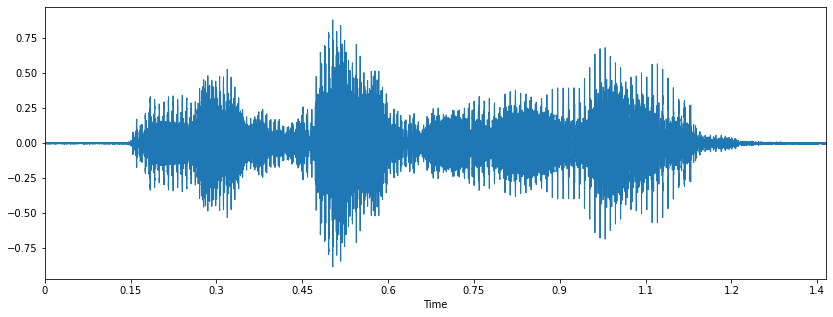

In [15]:
### Making waveplots
fig = plt.figure(figsize=(14,5))

ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][13])
lbl.waveplot(ads,sr=r)
Audio(ads,rate=r)

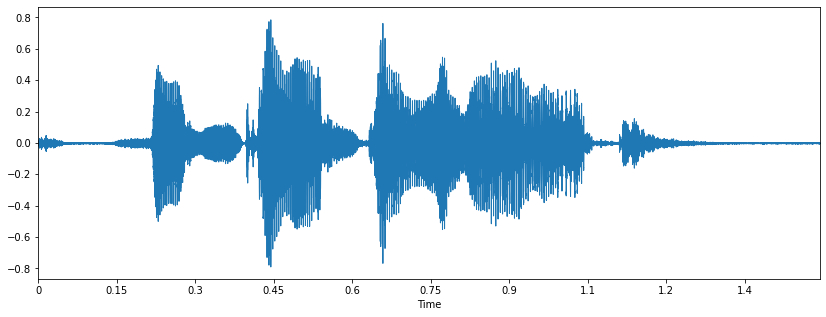

In [16]:
fig = plt.figure(figsize=(14,5))

ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][34])
lbl.waveplot(ads,sr=r)
Audio(ads,rate=r)

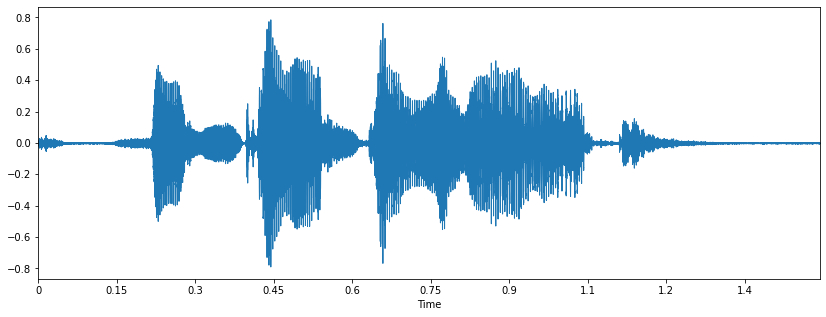

In [17]:
fig = plt.figure(figsize=(14,5))

ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][4])
lbl.waveplot(ads,sr=r)
Audio(ads,rate=r)

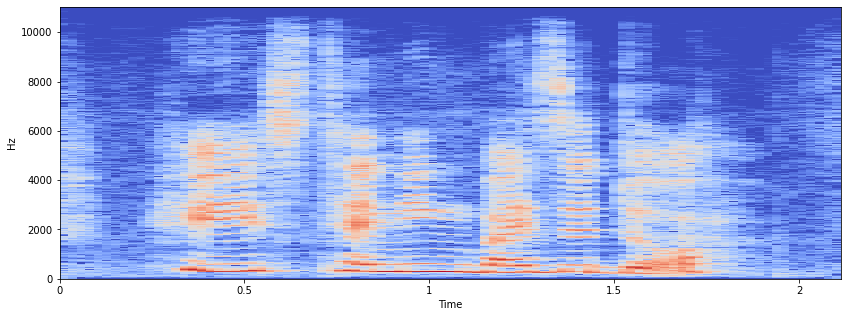

In [18]:
### Making spectograms and showing Specsshow
fig = plt.figure(figsize=(14,5))

ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][45])

stft = lbr.stft(ads)
db = lbr.amplitude_to_db(abs(stft))
lbl.specshow(db,sr=r,x_axis="time",y_axis="hz")
Audio(ads,rate=r)

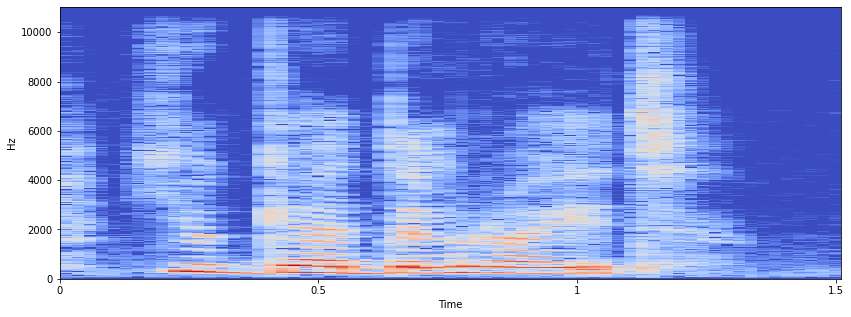

In [19]:
fig = plt.figure(figsize=(14,5))

ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][4])

stft = lbr.stft(ads)
db = lbr.amplitude_to_db(abs(stft))
lbl.specshow(db,sr=r,x_axis="time",y_axis="hz")
Audio(ads,rate=r)

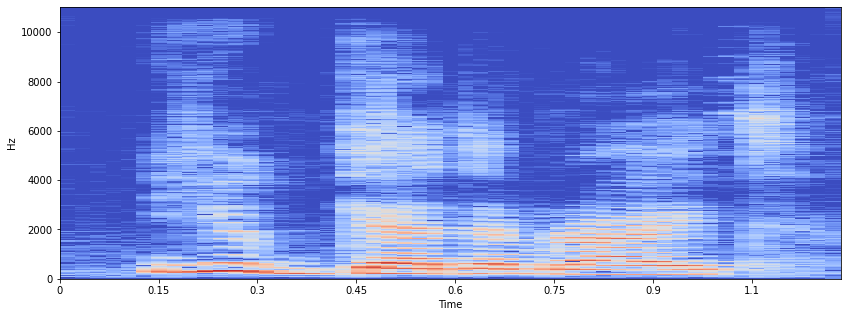

In [20]:
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20])

stft = lbr.stft(ads)
db = lbr.amplitude_to_db(abs(stft))
lbl.specshow(db,sr=r,x_axis="time",y_axis="hz")
Audio(ads,rate=r)

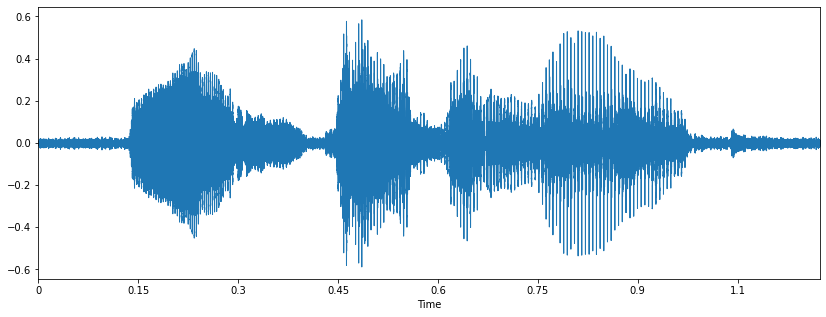

In [21]:
### Here adding noise
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20])

noise_injection = add_noise(ads)

lbl.waveplot(noise_injection,sr=sr)
Audio(noise_injection,rate=sr)

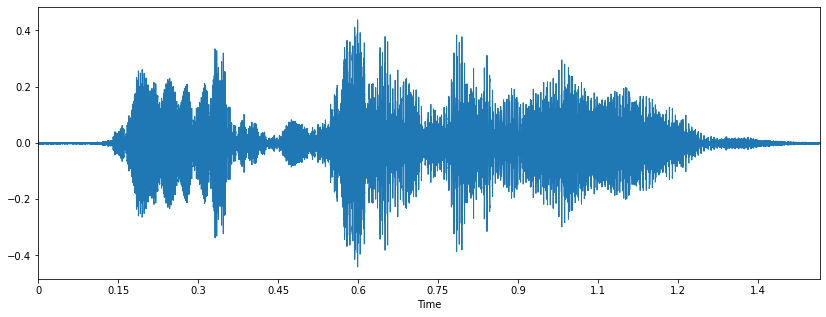

In [22]:
### Here apllying stretch process
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20])

stretching_audio = stretch_process(ads)
lbl.waveplot(stretching_audio,sr=sr)
Audio(stretching_audio,rate=sr)

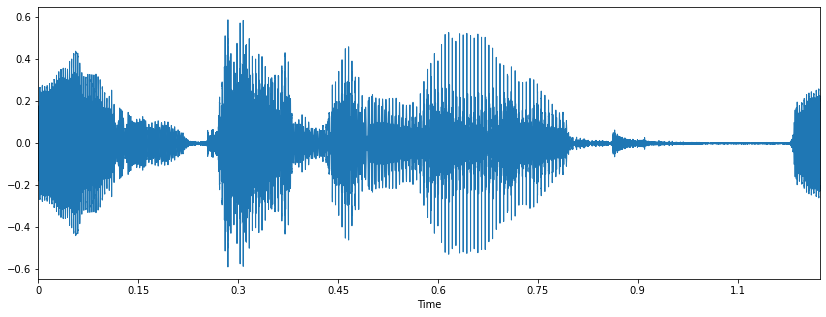

In [23]:
### Here apllying shifting process
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20])

shifting_audio = shift_process(ads)
lbl.waveplot(shifting_audio,sr=sr)
Audio(shifting_audio,rate=sr)

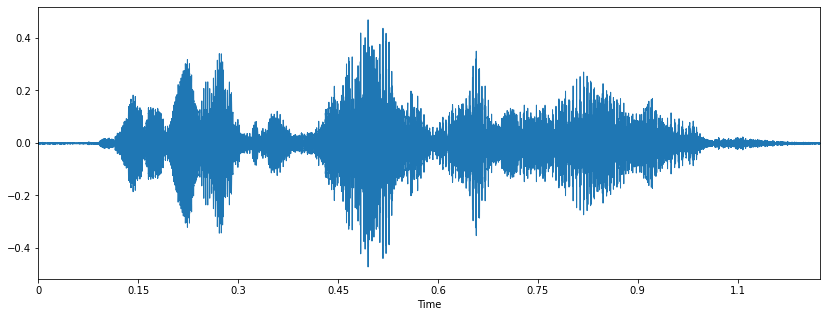

In [24]:
### Here apllying pitch process
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20])

pitch_audio = pitch_process(ads,sr)
lbl.waveplot(pitch_audio,sr=sr)
Audio(pitch_audio,rate=sr)

(19698,)


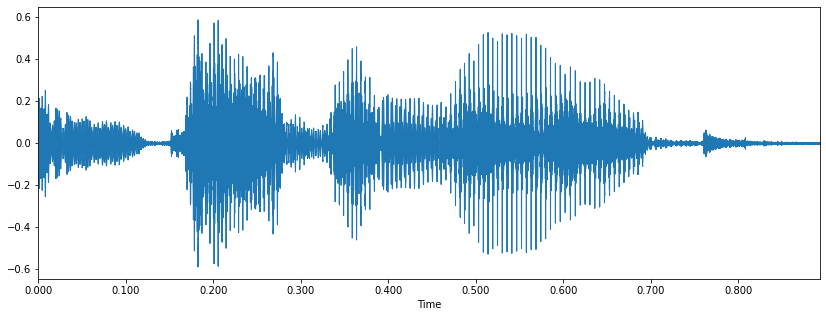

In [25]:
### Here we apllying the same time frame period
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][20],duration=2,offset=0.28)
lbl.waveplot(ads,sr=sr)
print(ads.shape)
Audio(ads,rate=sr)

(39161,)


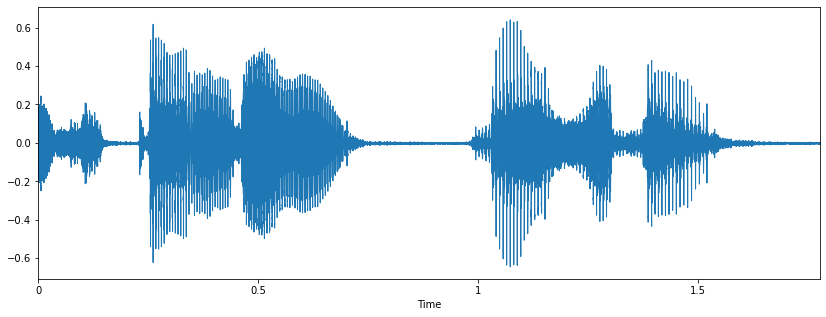

In [26]:
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][3],duration=2,offset=0.4)
lbl.waveplot(ads,sr=sr)
print(ads.shape)
Audio(ads,rate=sr)

(44100,)


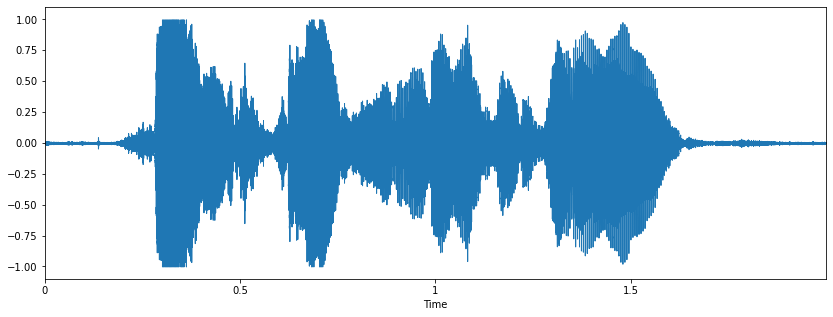

In [27]:
fig = plt.figure(figsize=(14,5))

ads,sr = lbr.load(Main1_WAVRECORDING_Data["WAV"][55],duration=2,offset=0.15)
lbl.waveplot(ads,sr=sr)
print(ads.shape)
Audio(ads,rate=sr)

In [28]:
##fig = plt.figure(figsize=(14,5))

#ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][45])

#melspectro = lbr.stft(ads)
#db = lbr.amplitude_to_db(abs(melspectro))
#lbl.specshow(db,sr=r,x_axis="time",y_axis="hz")
#Audio(ads,rate=r)

#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#ads,r = lbr.load(Main1_WAVRECORDING_Data["WAV"][45])
#melspectro = librosa.power_to_db(S, ref=np.max)
#img = librosa.display.specshow(S_dB, x_axis='time',
 #                        y_axis='mel', sr=sr,
 #                        fmax=8000, ax=ax)
#fig.colorbar(img, ax=ax, format='%+2.0f dB')
#ax.set(title='Mel-frequency spectrogram')


In [29]:
#Data preparation for neural networks 
Train_gx = []
Train_gy = []

for dir,sentiment in zip(Main1_WAVRECORDING_Data.WAV,Main1_WAVRECORDING_Data.sentiment):
    comp = export_process(dir)
    
    for unit in comp:
        Train_gx.append(unit)
        Train_gy.append(sentiment)

In [30]:
print(len(Train_gx))
print(len(Train_gy))
print(len(Main1_WAVRECORDING_Data.WAV))
print(Train_gx[0].shape)
print(Train_gy[0:90])

360
360
120
(162,)
['happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'calm', 'calm', 'calm', 'fear', 'fear', 'fear', 'sad', 'sad', 'sad', 'happy', 'happy', 'happy', 'fear', 'fear', 'fear', 'calm', 'calm', 'calm', 'happy', 'happy', 'happy', 'calm', 'calm', 'calm', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'calm', 'calm', 'calm', 'angry', 'angry', 'angry', 'fear', 'fear', 'fear', 'sad', 'sad', 'sad', 'happy', 'happy', 'happy', 'calm', 'calm', 'calm', 'angry', 'angry', 'angry', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'angry', 'angry', 'angry', 'happy', 'happy', 'happy', 'fear', 'fear', 'fear', 'happy', 'happy', 'happy', 'calm', 'calm', 'calm', 'sad', 'sad', 'sad', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm']


In [31]:
# Create *.csv file
Specs = pd.DataFrame(Train_gx)
Specs["sentiments"] = Train_gy

Specs.to_csv("SAVE.csv",index=False)

In [32]:
Specs.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,sentiments
0,0.131733,0.569969,0.532708,0.585535,0.656357,0.585102,0.451426,0.389129,0.402593,0.481526,...,0.003544,0.003557,0.002569,0.001096,0.000755,0.000529,0.000367,1.427366e-04,1.420992e-05,happy
1,0.209383,0.622371,0.640529,0.709715,0.737084,0.678139,0.514133,0.496208,0.519919,0.620839,...,0.015286,0.015953,0.015489,0.014440,0.014038,0.015054,0.012511,1.292270e-02,1.385696e-02,happy
2,0.164873,0.682675,0.588925,0.616016,0.679594,0.670974,0.562753,0.437199,0.488445,0.475889,...,0.000529,0.000678,0.000948,0.000783,0.000524,0.000247,0.000120,4.260328e-05,1.162367e-05,happy
3,0.058129,0.470543,0.362499,0.523564,0.574654,0.363151,0.413927,0.542743,0.631766,0.683236,...,0.000253,0.000151,0.000196,0.000433,0.000499,0.000362,0.000086,2.172960e-05,2.042620e-06,sad
4,0.096052,0.687645,0.443924,0.453588,0.636634,0.531697,0.406813,0.513008,0.602084,0.702059,...,0.000970,0.000829,0.000908,0.001047,0.001132,0.001095,0.000786,7.224398e-04,7.158262e-04,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.073355,0.500635,0.552596,0.539383,0.550466,0.584852,0.489545,0.466760,0.554017,0.812167,...,0.000118,0.000091,0.000053,0.000019,0.000013,0.000009,0.000006,3.811872e-06,1.769763e-06,sad
355,0.201385,0.560582,0.621050,0.603197,0.617469,0.666739,0.546332,0.498668,0.557127,0.755250,...,0.000865,0.000834,0.000902,0.000862,0.000810,0.000838,0.000784,8.120791e-04,8.444758e-04,sad
356,0.070621,0.500175,0.509917,0.561530,0.496165,0.485920,0.526100,0.460724,0.444124,0.489670,...,0.000037,0.000032,0.000025,0.000017,0.000010,0.000003,0.000003,5.854436e-07,9.035400e-08,sad
357,0.094478,0.708161,0.621561,0.465991,0.437433,0.462351,0.434350,0.408738,0.476337,0.568413,...,0.002325,0.001235,0.000494,0.000166,0.000290,0.000451,0.000406,2.499750e-04,1.759310e-05,fear


In [33]:
print(Specs["sentiments"].value_counts())

happy    72
sad      72
calm     72
fear     72
angry    72
Name: sentiments, dtype: int64


In [34]:
### Spliting
hot_encoder = OneHotEncoder()


In [35]:
aX = Specs.iloc[:,:-1].values
aY = Specs["sentiments"].values
aY = hot_encoder.fit_transform(numpy.array(aY).reshape(-1,1)).toarray()

In [36]:
aX.shape

(360, 162)

In [37]:
aY.shape

(360, 5)

In [38]:
### 
ax_Train,ax_Test,ay_Train,ay_Test = train_test_split(aX,aY,train_size=0.9,random_state=42,shuffle=True)

In [39]:
ax_Train.shape

(324, 162)

In [40]:
ay_Train.shape


(324, 5)

In [41]:
ax_Test.shape

(36, 162)

In [42]:
ay_Test.shape

(36, 5)

In [43]:
sd_scal_val = StandardScaler()
ax_Train = sd_scal_val.fit_transform(ax_Train)
ax_Test = sd_scal_val.transform(ax_Test)

In [44]:
ax_Train.shape


(324, 162)

In [45]:
ax_Test.shape

(36, 162)

In [46]:
ax_Train = numpy.expand_dims(ax_Train,axis=2)
ax_Test = numpy.expand_dims(ax_Test,axis=2)

In [47]:
ax_Test.shape

(36, 162, 1)

In [48]:
ax_Train.shape

(324, 162, 1)

In [49]:
import optuna

In [50]:
#Set layers of the Model
### Bit different sug to change double filter change filter size leave strides change dropout 0.5 trying to get bett optuna
### optuna for optimiztion!!!!!
Model=Sequential()
Model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(ax_Train.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, padding = 'same' ))

Model.add(Conv1D(filters=256, kernel_size=5,padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, padding = 'same'))
Model.add(Dropout(0.1))

Model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.1))

Model.add(Dense(units=5, activation='softmax')) #units = 5




2022-02-28 08:54:17.847044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 08:54:17.955196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 08:54:17.955901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 08:54:17.957052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [51]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [52]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [53]:
"""
Optuna example that optimizes a neural network classifier configuration for the
MNIST dataset using Keras.
In this example, we optimize the validation accuracy of MNIST classification using
Keras. We optimize the filter and kernel size, kernel stride and layer activation.

import urllib
import warnings

import optuna

from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop


# TODO(crcrpar): Remove the below three lines once everything is ok.
# Register a global custom opener to avoid HTTP Error 403: Forbidden when downloading MNIST.
opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)



BATCHSIZE = 128
CLASSES = 10
EPOCHS = 20
units = 5
Dropout = 0.5
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    Train_gx = []
    Train_gy = []

    for dir,sentiment in zip(Main1_WAVRECORDING_Data.WAV,Main1_WAVRECORDING_Data.sentiment):
        comp = export_process(dir)
    
        for unit in comp:
            Train_gx.append(unit)
            Train_gy.append(sentiment)
    Specs = pd.DataFrame(Train_gx)
    Specs["sentiments"] = Train_gy
    Specs.to_csv("SAVE.csv",index=False)
    hot_encoder = OneHotEncoder()
    aX = Specs.iloc[:,:-1].values
    aY = Specs["sentiments"].values
    aY = hot_encoder.fit_transform(numpy.array(aY).reshape(-1,1)).toarray()
    ax_Train,ax_Test,ay_Train,ay_Test = train_test_split(aX,aY,train_size=0.9,random_state=42,shuffle=True)
    sd_scal_val = StandardScaler()
    ax_Train = sd_scal_val.fit_transform(ax_Train)
    ax_Test = sd_scal_val.transform(ax_Test)
    ax_Train = numpy.expand_dims(ax_Train,axis=2)
    ax_Test = numpy.expand_dims(ax_Test,axis=2)


    model = Sequential()
    model.add(
        Conv1D(
            filters=trial.suggest_categorical("filters", [32, 64, 128, 256]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5]),
            activation=trial.suggest_categorical("activation", ["relu", "linear"]),
            input_shape=(ax_Train.shape[1], 1)
        )
    )
    model.add(Flatten())
    model.add(Dense(units=units, activation="softmax"))

    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    model.compile(
        loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"]
    )
######(lr=lr)
    model.fit(
        ax_Train,
        ay_Train,
        validation_data=(ax_Test, ay_Test),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(ax_Test,ay_Test, verbose=0)
    return score[1]


if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=35, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))"""

'\nOptuna example that optimizes a neural network classifier configuration for the\nMNIST dataset using Keras.\nIn this example, we optimize the validation accuracy of MNIST classification using\nKeras. We optimize the filter and kernel size, kernel stride and layer activation.\n\nimport urllib\nimport warnings\n\nimport optuna\n\nfrom keras.backend import clear_session\nfrom keras.datasets import mnist\nfrom keras.layers import Conv2D\nfrom keras.layers import Dense\nfrom keras.layers import Flatten\nfrom keras.models import Sequential\nfrom tensorflow.keras.optimizers import RMSprop\n\n\n# TODO(crcrpar): Remove the below three lines once everything is ok.\n# Register a global custom opener to avoid HTTP Error 403: Forbidden when downloading MNIST.\nopener = urllib.request.build_opener()\nopener.addheaders = [("User-agent", "Mozilla/5.0")]\nurllib.request.install_opener(opener)\n\n\n\nBATCHSIZE = 128\nCLASSES = 10\nEPOCHS = 20\nunits = 5\nDropout = 0.5\ndef objective(trial):\n    # Cl

In [54]:
#Check the shape of the prepared data(1234567890)




#Train Model
MainModel = Model.fit(ax_Train, ay_Train, batch_size=128, epochs=100, verbose = 2, callbacks=[EarlyStopping], validation_data=(ax_Test, ay_Test))

2022-02-28 08:54:21.802263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-02-28 08:54:23.155888: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 - 7s - loss: 1.5653 - accuracy: 0.2253 - val_loss: 1.5498 - val_accuracy: 0.3056
Epoch 2/100
3/3 - 0s - loss: 1.4047 - accuracy: 0.3704 - val_loss: 1.4277 - val_accuracy: 0.3333
Epoch 3/100
3/3 - 0s - loss: 1.3439 - accuracy: 0.3549 - val_loss: 1.5061 - val_accuracy: 0.3611
Epoch 4/100
3/3 - 0s - loss: 1.3014 - accuracy: 0.4290 - val_loss: 1.4803 - val_accuracy: 0.1944
Epoch 5/100
3/3 - 0s - loss: 1.2645 - accuracy: 0.4136 - val_loss: 1.3967 - val_accuracy: 0.3611
Epoch 6/100
3/3 - 0s - loss: 1.2053 - accuracy: 0.4043 - val_loss: 1.3159 - val_accuracy: 0.3889
Epoch 7/100
3/3 - 0s - loss: 1.1842 - accuracy: 0.4660 - val_loss: 1.2414 - val_accuracy: 0.4167
Epoch 8/100
3/3 - 0s - loss: 1.1230 - accuracy: 0.5154 - val_loss: 1.2514 - val_accuracy: 0.4167
Epoch 9/100
3/3 - 0s - loss: 1.1126 - accuracy: 0.5062 - val_loss: 1.3118 - val_accuracy: 0.3611
Epoch 10/100
3/3 - 0s - loss: 1.0900 - accuracy: 0.5062 - val_loss: 1.1962 - val_accuracy: 0.5278
Epoch 11/100
3/3 - 0s - loss: 1.0364 - ac

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

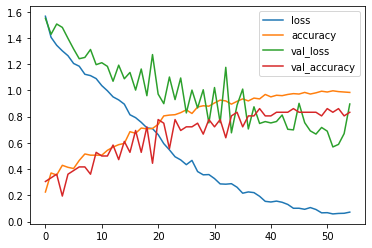

In [55]:
plot_data = pd.DataFrame(MainModel.history)
fig = plt.figure(figsize=(10,10))
plot_data.plot()

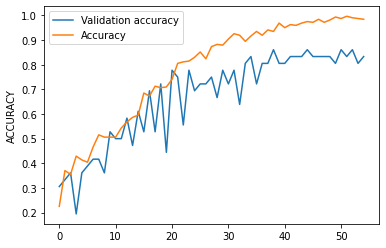

In [56]:
plt.plot(MainModel.history["val_accuracy"])
plt.plot(MainModel.history["accuracy"])
plt.ylabel("ACCURACY")
plt.legend(["Validation accuracy","Accuracy"])
plt.show()

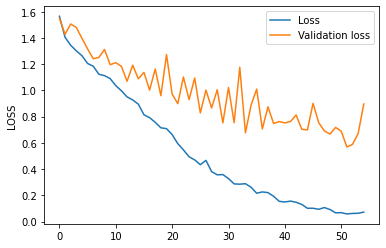

In [57]:
plt.plot(MainModel.history["loss"])
plt.plot(MainModel.history["val_loss"])
plt.ylabel("LOSS")
plt.legend(['Loss','Validation loss'])
plt.show()

In [58]:
MResults = Model.evaluate(ax_Test,ay_Test)
print("LOSS:  " + "%.4f" % MResults[0])
print("ACCURACY:  " + "%.4f" % MResults[1])

2/2 [==============================] - 0s 129ms/step - loss: 0.8963 - accuracy: 0.8333
LOSS:  0.8963
ACCURACY:  0.8333


In [59]:
ax_Test_predict = Model.predict(ax_Test)
ay_predict = hot_encoder.inverse_transform(ax_Test_predict)
ay_Test = hot_encoder.inverse_transform(ay_Test)

In [60]:
print(ax_Test_predict[0:10])

[[3.64291445e-05 5.18149137e-03 6.93181250e-03 1.04503515e-05
  9.87839758e-01]
 [9.96424615e-01 1.10823940e-10 5.38996714e-09 3.57269379e-03
  2.57976831e-06]
 [4.54854578e-01 3.90614895e-03 1.14369774e-02 5.26001930e-01
  3.80037236e-03]
 [7.57633328e-01 3.00464453e-03 1.37862563e-01 8.76909643e-02
  1.38084926e-02]
 [1.60747845e-07 9.99921679e-01 1.16279180e-05 5.86959504e-06
  6.06469766e-05]
 [2.38190413e-01 1.48191052e-02 1.20846322e-03 6.88836455e-01
  5.69455326e-02]
 [1.01321608e-01 9.97348577e-02 1.78343207e-01 2.25858867e-01
  3.94741446e-01]
 [9.36711669e-01 1.55590556e-06 9.43465682e-04 6.22796081e-02
  6.36096665e-05]
 [4.66891145e-03 5.59491809e-07 8.85425031e-01 2.71396711e-04
  1.09634116e-01]
 [9.99979615e-01 3.53373807e-19 9.13167653e-10 2.03348882e-05
  7.30558040e-15]]


In [61]:
print(ay_predict[0:10])

[['sad']
 ['angry']
 ['happy']
 ['angry']
 ['calm']
 ['happy']
 ['sad']
 ['angry']
 ['fear']
 ['angry']]


In [62]:
print(ay_Test[0:10])

[['sad']
 ['angry']
 ['angry']
 ['angry']
 ['calm']
 ['happy']
 ['sad']
 ['angry']
 ['fear']
 ['angry']]


In [63]:
confusion_matrix = confusion_matrix(ay_Test, ay_predict)

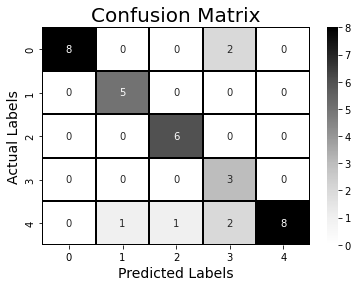

In [64]:
sns.heatmap(confusion_matrix, linecolor='Black', annot=True, cmap='Greys', linewidth=2, fmt='0')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [65]:
print(classification_report(ay_Test, ay_predict))

              precision    recall  f1-score   support

       angry       1.00      0.80      0.89        10
        calm       0.83      1.00      0.91         5
        fear       0.86      1.00      0.92         6
       happy       0.43      1.00      0.60         3
         sad       1.00      0.67      0.80        12

    accuracy                           0.83        36
   macro avg       0.82      0.89      0.82        36
weighted avg       0.91      0.83      0.84        36



In [66]:
print(accuracy_score(ay_Test, ay_predict))

0.8333333333333334


In [67]:
#export model
filename = "Trained_Recog_Model.h5"
Model.save(filename)

In [68]:
#import Model 
Model_New = load_model('Trained_Recog_Model.h5')

#import Test dataset
Main_Test_Path = Path("/kaggle/input/test-privet-datasetl2/Test PD L2")
Test_Path = list(Main_Test_Path.glob(r"**/*.wav"))
Test_Path_Series = pd.Series(Test_Path,name="WAV").astype(str)
MainTest_Wav_Data = pd.concat([Test_Path_Series],axis=1)
MainTest_Wav_Data = MainTest_Wav_Data.sample(frac=1).reset_index(drop=True)

Test = []
freq = 0
        
for path in MainTest_Wav_Data.WAV:
    
    comp = export_process(path)
    
    for unit in comp:
         Test.append(unit)

Test = pd.DataFrame(Test)
Test = Test.iloc[:,:-1].values
Test = sd_scal_val.fit_transform(Test)
Test = numpy.expand_dims(Test,axis=2)
print(Test.shape)

(60, 161, 1)


In [69]:
#Model prediction for new dataset(test-voice)
Test_Prediction = Model_New.predict(Test)
Prediction = hot_encoder.inverse_transform(Test_Prediction)

for i in range(len(Test_Path_Series)):
    print('File {Nr}: {Path} is {Prediction}.'.format(Nr = i,Path=Test_Path_Series[i], Prediction=Prediction[i]))

File 0: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_06_05.wav is ['calm'].
File 1: /kaggle/input/test-privet-datasetl2/Test PD L2/01_01_09_03.wav is ['calm'].
File 2: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_10_02.wav is ['calm'].
File 3: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_05_05.wav is ['calm'].
File 4: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_06_01.wav is ['calm'].
File 5: /kaggle/input/test-privet-datasetl2/Test PD L2/01_01_08_03.wav is ['calm'].
File 6: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_04_04.wav is ['angry'].
File 7: /kaggle/input/test-privet-datasetl2/Test PD L2/01_01_09_04.wav is ['angry'].
File 8: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_11_02.wav is ['happy'].
File 9: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_05_01.wav is ['angry'].
File 10: /kaggle/input/test-privet-datasetl2/Test PD L2/02_01_01_03.wav is ['angry'].
File 11: /kaggle/input/test-privet-datasetl2/Test PD L2/01_02_10_05.wa